# Thanker Experiment Power Analysis
[J. Nathan Matias](https://github.com/natematias)
July 2019

Some components of this are drawn from [github.com/natematias/poweranalysis-onlinebehavior](https://github.com/natematias/poweranalysis-onlinebehavior).

Eventually, this power analysis code will ask a series of questions of [historical data prepared by Max Klein](https://docs.google.com/document/d/1VTisnIBafttzCNPAlEV149Mhyqc7D2Q_96OA9hKmp_M/edit#) and produce a series of answers used for power analysis and study design in CivilServant's research with Wikipedians on [the effects of giving thanks to other Wikipedians](https://meta.wikimedia.org/wiki/Research:Testing_capacity_of_expressions_of_gratitude_to_enhance_experience_and_motivation_of_editors):
* The experiment plan is on Overleaf: [Experiment Plan: Mentoring and Protection in Wikipedia Moderation](https://www.overleaf.com/project/5c376605f882d02f5b8c714a)

This analysis will define and report the following:

* Assumptions about minimum observable treatment effects for each DV
* Reports on the statistical power, bias, and type S error rate for all possible estimators, given the above assumptions
* Data-driven decisions:
    * Decisions about the final set of measures to use
    * Decisions about the final estimators to use
    * Decisions about the sample size to specify for the experiment
    * Decisions about any stop rules to use in the experiment

**Note:** Since the thanker study will involve a single group of participants from multiple language Wikipedias, this document reports a single power analysis. The experiment for thanks recipients covers multiple language Wikipedias.

In [1]:
## LOAD LIBRARIES
options("scipen"=9, "digits"=4)
library(dplyr)
library(MASS)
library(ggplot2)
library(rlang)
library(tidyverse)
library(viridis)
library(gmodels)
library(DeclareDesign)
library(skimr)
library(corrplot)
library(blockTools)
library(beepr)
# ## Installed DeclareDesign 0.13 using the following command:
# # install.packages("DeclareDesign", dependencies = TRUE,
# #                 repos = c("http://R.declaredesign.org", "https://cloud.r-project.org"))

## DOCUMENTATION AT: https://cran.r-project.org/web/packages/DeclareDesign/DeclareDesign.pdf
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.2     ✔ stringr 1.3.1
✔ readr   1.2.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()        masks rlang::%||%()
✖ purrr::%@%()         masks rlang::%@%()
✖ purrr::as_function() masks rlang::as_function()
✖ dplyr::filter()      masks stats::filter()
✖ purrr::flatten()     masks rlang::flatten()
✖ purrr::flatten_chr() masks rlang::flatten_chr()
✖ purrr::flatten_dbl() masks rlang::flatten_dbl()
✖ purrr::flatten_int() masks rlang::flatten_int()
✖ purrr::flatten_lgl() masks rlang::flatten_lgl()
✖ purrr::inv

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.5 LTS

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.6.0
LAPACK: /usr/lib/lapack/liblapack.so.3.6.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] beepr_1.3            blockTools_0.6-3     corrplot_0.84       
 [4] skimr_1.0.4          DeclareDesign_0.12.0 estimatr_0.14       
 [7] fabricatr_0.6.0      randomizr_0.16.1     gmodels_2.18.1      
[10] viridis_0.5.1        viridisLite_0.3.0    forcats_0.3.0       
[13] stringr_1.3.1        pur

# Configuration Settings

In [2]:
data.path <- "~/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/datasets/power_analysis"

# Step one: Creating a Plausible Population to Draw From

### Load Thanker Power Analysis Datasets As Proxy for Thankers

In [3]:
data.path <- "~/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/datasets/power_analysis"
power.df <- read.csv(file.path(data.path, "thanker_power_analysis_data_for_sim_treatment_20180306_active_only.csv"))

simulated.treatment.date <- as.Date("20180306", "%Y%M%D")

### Load Power Analysis Utility Methods

In [4]:
source("../power-analysis-utilities.R")
source("../wikipedia-gratitude-utilities.R")

# Summarize Thanker Power Analysis Dataframe

In [5]:
subset.summarize.thanker.data <- function(thanker.df, l, trim=TRUE){
    sim.df <- subset(thanker.df, lang==l)
    sim.df$supportive_90_pre_treatment <- rowSums(sim.df[,
                                                      c("support_talk_90_pre_treatment",
                                                        "wikithank_90_pre_treatment")], na.rm=TRUE)
    sim.df$protective_90_pre_treatment <- rowSums(sim.df[,
                                                      c("block_actions_90_pre_treatment",
                                                        "num_reverts_90_pre_treatment")], na.rm=TRUE)
    
    sim.df$supportive_90_post_treatment <- rowSums(sim.df[,
                                                       c("support_talk_90_post_treatment",
                                                         "wikithank_90_post_treatment")], na.rm=TRUE)
    sim.df$protective_90_post_treatment <- rowSums(sim.df[,
                                                       c("block_actions_90_post_treatment",
                                                          "num_reverts_90_post_treatment")], na.rm=TRUE)
    
    ### REMOVING OUTLIERS beyond 99% confidence interval (MIGHT BE A BAD IDEA, UNSURE)
    if(trim==TRUE){
        sim.support.mean <- mean(sim.df$support_talk_90_pre_treatment)
        sim.support.sd   <- sd(sim.df$support_talk_90_pre_treatment)
        sim.df <- subset(sim.df, support_talk_90_pre_treatment <= sim.support.mean + 2.58* sim.support.sd)
    }
    
    
    corrplot(cor(sim.df[,c("support_talk_90_pre_treatment",
                     "project_talk_90_pre_treatment",
                     "wikithank_90_pre_treatment",
                     "wikilove_90_pre_treatment",
                     "num_reverts_90_pre_treatment")]),
            type="upper", method = "ellipse")
    
    sim.df$supportive_diff_180_days <- sim.df$supportive_90_post_treatment - sim.df$supportive_90_pre_treatment

    sim.df$protective_diff_180_days <- sim.df$protective_90_post_treatment - sim.df$protective_90_pre_treatment
    
    sim.df$supportive_protective_ratio_pre_90_days <- sim.df$supportive_90_pre_treatment / (sim.df$supportive_90_pre_treatment +sim.df$protective_90_pre_treatment + 1)  

    plt <- ggplot(sim.df, aes(protective_90_pre_treatment, supportive_90_pre_treatment, color=supportive_protective_ratio_pre_90_days)) +
        geom_abline(intercept = 0, color="grey", linetype="dashed") +
        geom_jitter(size=1) +
        scale_colour_gradient(name="% Support Actions") +
        theme_bw() +
        ggtitle(paste(l, "Supportive and Protective Actions Before Treatment"))
    print(plt)

    plt2 <- ggplot(sim.df, aes(protective_diff_180_days, supportive_diff_180_days , color=supportive_protective_ratio_pre_90_days)) +
        geom_hline(yintercept = 0, color="grey", linetype="dashed") +        
        geom_vline(xintercept = 0, color="grey", linetype="dashed") +        
        geom_point() +
        theme_bw() +
        scale_colour_gradient(name="% Support Actions") +
        ggtitle(paste(l, "Diff in Supportive and Protective Actions"))
    print(plt2)
    
    plt3 <- ggplot(sim.df, aes(log1p(wikithank_90_pre_treatment))) +
        geom_histogram() +         
        theme_bw() +
        ggtitle(paste(l, "Thanks Given 90 Days Previously"))

    print(plt3)

    sim.df
}

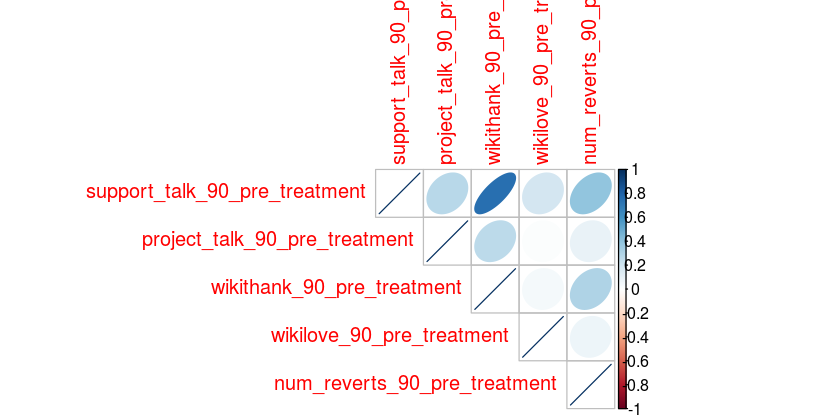

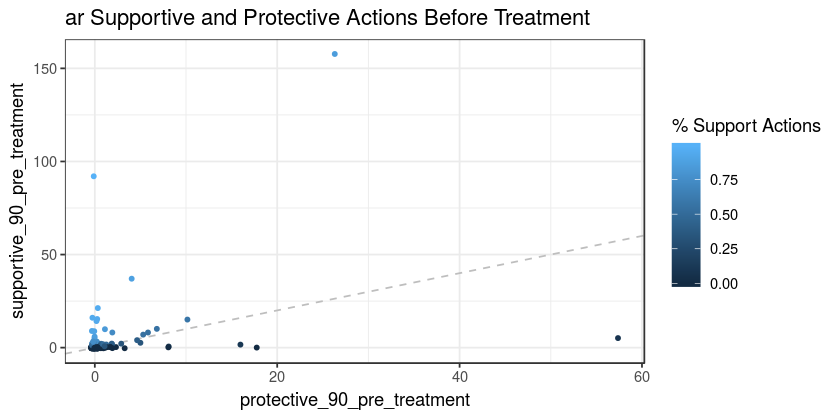

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


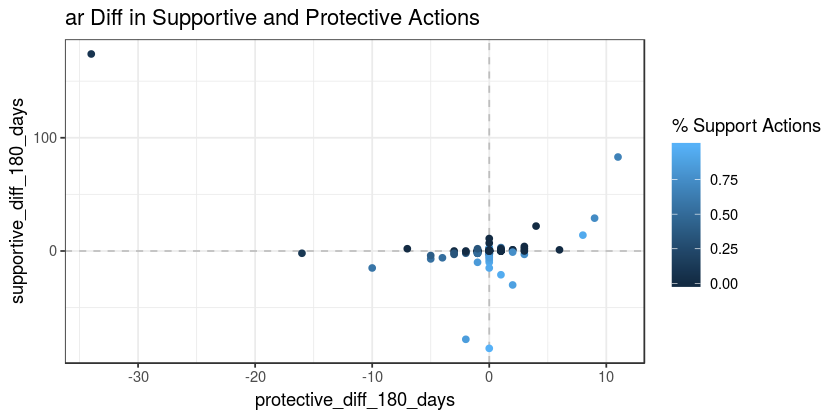

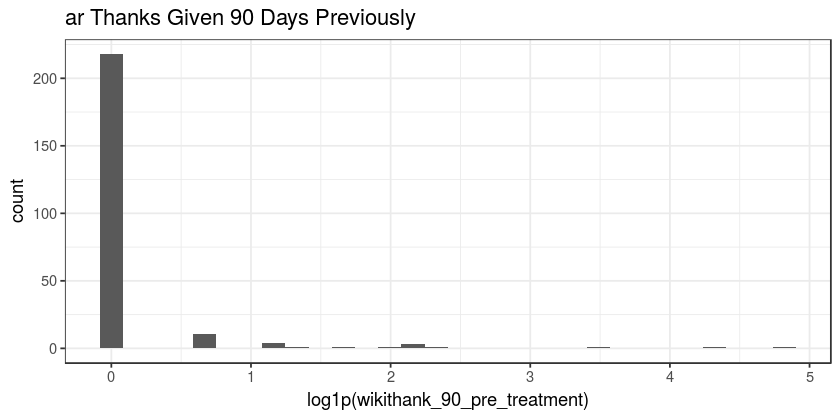

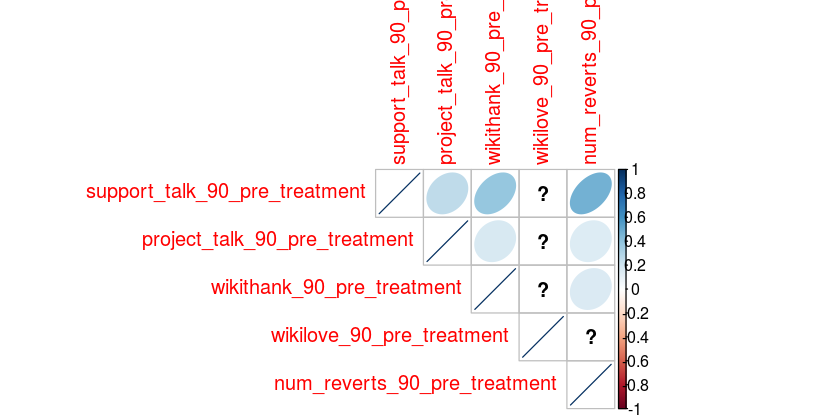

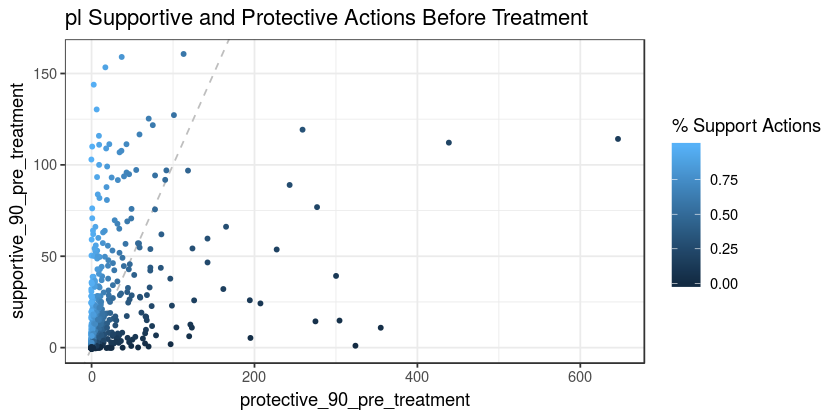

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


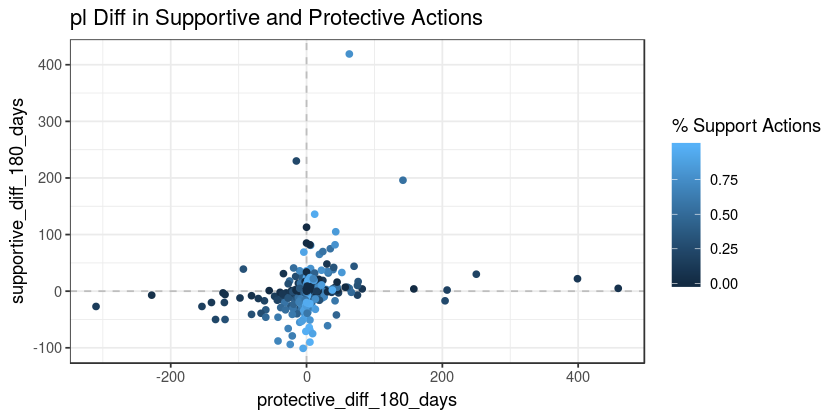

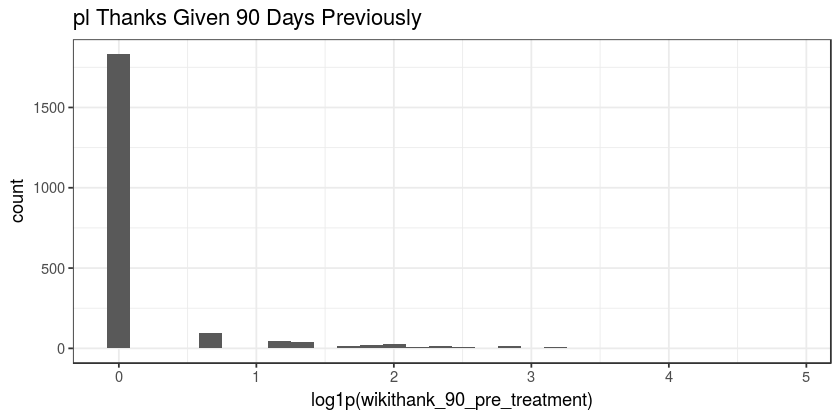

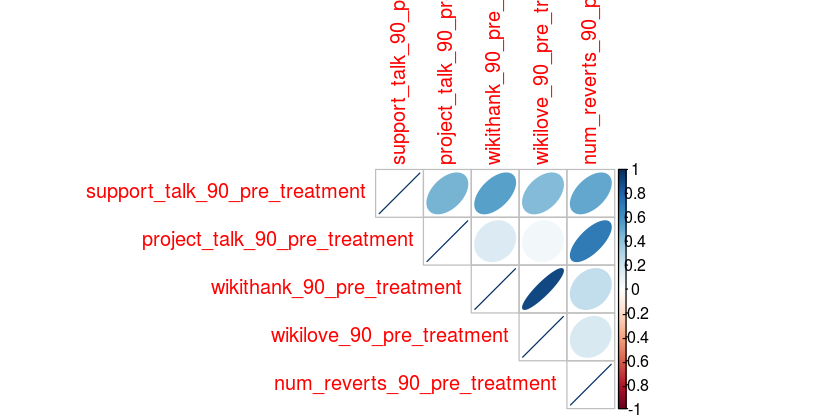

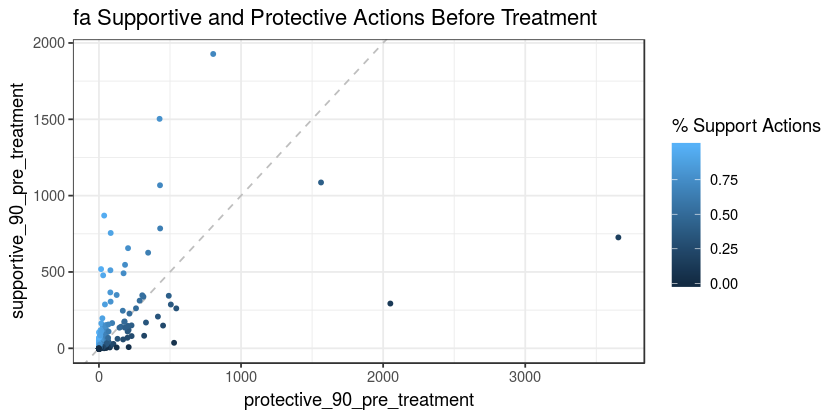

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


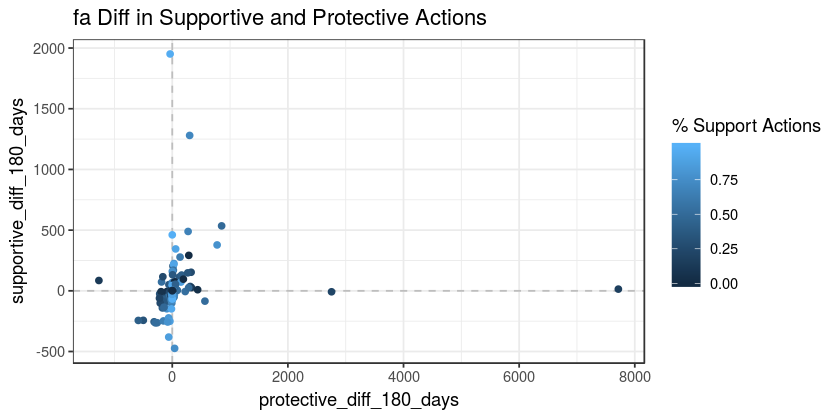

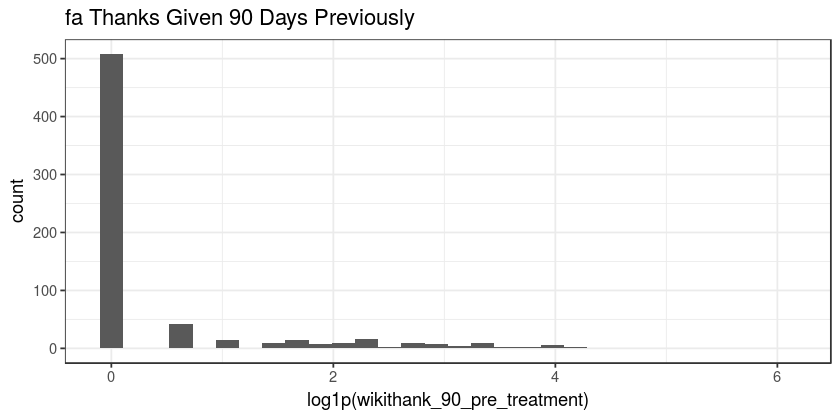

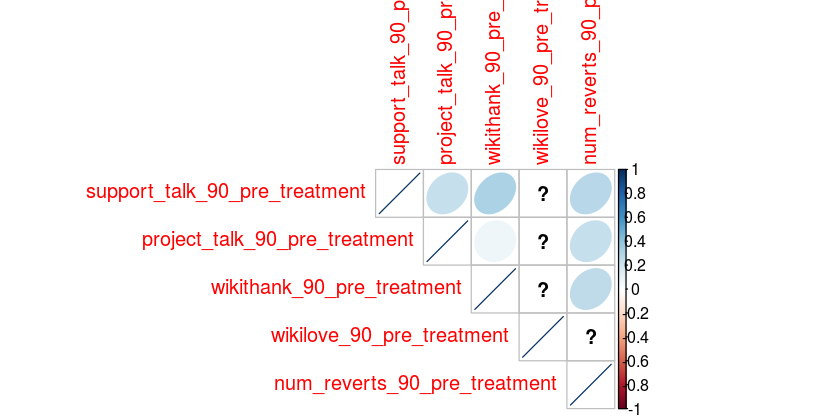

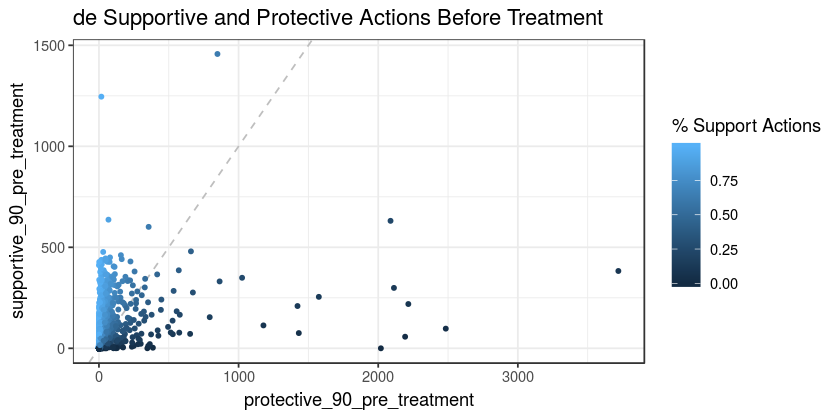

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


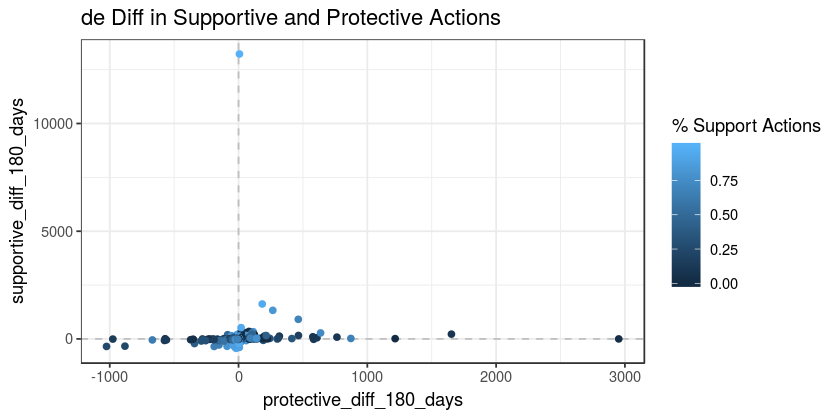

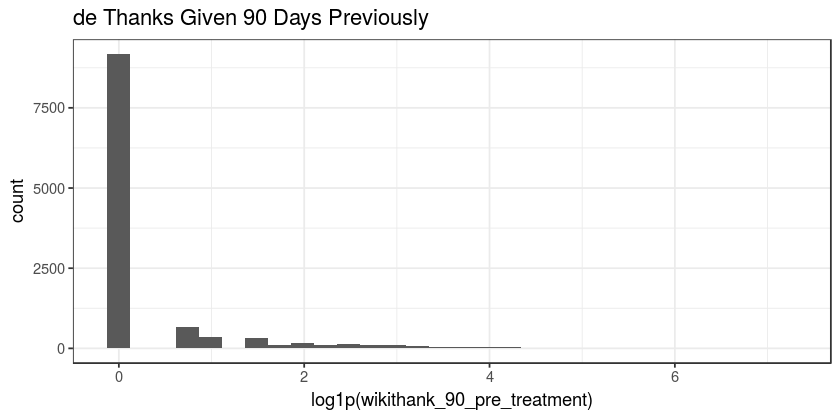

In [6]:
## To test the effect of not trimming extreme values, set trim=FALSE
ar.thanker.df <- subset.summarize.thanker.data(power.df, "ar")#, trim=FALSE)
pl.thanker.df <- subset.summarize.thanker.data(power.df, "pl")#, trim=FALSE)
fa.thanker.df <- subset.summarize.thanker.data(power.df, "fa")#, trim=FALSE)
de.thanker.df <- subset.summarize.thanker.data(power.df, "de")#, trim=FALSE)
power.sub.df <- rbind(ar.thanker.df,pl.thanker.df, fa.thanker.df,de.thanker.df)

# Set Up Power Analysis Configuration
We make the assumption that Wikipedians group themselves into deletionists and inclusionists and that these groups will be reflected in the distribution of the survey.protectiveness.index, which will use the first component in a Principal Components Analysis to combine:
* Monitoring and correcting potentially damaging content
* Answering newcomer questions or mentoring newcomers in other ways

### Configure Thanker Dataframe

In [166]:
pa.config.thanker <- data.frame(
    n.max    = 450, # max number of observations
    n.min    = 100,  # min number of observations
        
    total.participation.rate = 0.8, # let's assume 80% of consented participants complete the study
    
    # the minimum effect we want to be able to observe:
    # a six edit increase in the number of protective edits over 90 days
    # assumption, the treatment group has the same standard deviation
    supportive.edit.diff.mean.effect = 6,
    supportive.edit.diff.sd.effect =   3,
    
    ## EFFECT ON DIFFERENCE IN NUMBER OF THANKS GIVEN
    thanks.given.diff.treat = 1.5,
    thanks.given.diff.treat.sd = 0.5,
    
    ## SURVEY RESULTS (ASSUMPTION: NO DIFFERENCE OVER TIME BETWEEN SURVEYS)
    ## feeling positive about one's contributions
    ## scale of 1 to 6
    ## imagine an 0.8 increase on average
    survey.feeling.positive = 4.26,    
    survey.feeling.postive.sd = 0.92,
    survey.feeling.positive.post.mean.ctl = 4.26,
    survey.feeling.positive.post.mean.treat = 4.66
)

# Creating a Sample of Thankers Proportional to What We Expect from Volunteers

In this study, we will publish banner ads to the following groups:
* In Arabic Wikipedia, accounts that have "autoreviewer" status.
* In German Wikipedia accounts that have permission to flag revisions.
* In Persian Wikipedia, accounts registered for at least one year with at least 500 edits.
* In Polish Wikipedia, accounts with permission to flag revisions.

In [167]:
fa.volunteer.count <- 54  ## 75 anticipated
pl.volunteer.count <- 66  ## 75 anticipated
de.volunteer.count <- 298 ## 300 anticipated

included.experience.levels <- c("730", "365", "1460", "2920")

In [168]:
## THESE SCRIPTS WILL EVENLY SAMPLE FROM ACROSS EXPERIENCE LEVELS
generate.complete.thanker.sample <- function(sub.df){
    fa.volunteers <- generate.sample.from.reference(subset(sub.df, lang=="fa" & fa_is_edits_enough=="True"), 
                               fa.volunteer.count, 
                                c("lang", 
                                  "wikithank_90_pre_treatment",      "wikilove_90_pre_treatment",
                                  "wikithank_90_post_treatment",     "wikilove_90_post_treatment",
                                  "block_actions_90_pre_treatment",  "support_talk_90_pre_treatment",
                                  "block_actions_90_post_treatment", "support_talk_90_post_treatment",
                                  "project_talk_90_pre_treatment",   "num_reverts_90_pre_treatment",
                                  "project_talk_90_post_treatment",  "num_reverts_90_post_treatment",
                                  "supportive_90_pre_treatment", "protective_90_pre_treatment",
                                  "supportive_90_post_treatment", "protective_90_post_treatment"
                                ), replacement= FALSE)

    pl.volunteers <- generate.sample.from.reference(subset(sub.df, lang=="pl" & pl_is_editor =="True"), 
                               pl.volunteer.count, 
                                c("lang", 
                                 "wikithank_90_pre_treatment",      "wikilove_90_pre_treatment",
                                 "wikithank_90_post_treatment",     "wikilove_90_post_treatment",
                                 "block_actions_90_pre_treatment",  "support_talk_90_pre_treatment",
                                 "block_actions_90_post_treatment", "support_talk_90_post_treatment",
                                 "project_talk_90_pre_treatment",   "num_reverts_90_pre_treatment",
                                 "project_talk_90_post_treatment",  "num_reverts_90_post_treatment",
                                  "supportive_90_pre_treatment", "protective_90_pre_treatment",
                                  "supportive_90_post_treatment", "protective_90_post_treatment"
                                ), replacement= FALSE)

    de.volunteers <- generate.sample.from.reference(subset(sub.df, lang=="de" & de_is_autoreviewer =="True"), 
                               de.volunteer.count, 
                                c("lang", 
                                 "wikithank_90_pre_treatment",      "wikilove_90_pre_treatment",
                                 "wikithank_90_post_treatment",     "wikilove_90_post_treatment",
                                 "block_actions_90_pre_treatment",  "support_talk_90_pre_treatment",
                                 "block_actions_90_post_treatment", "support_talk_90_post_treatment",
                                 "project_talk_90_pre_treatment",   "num_reverts_90_pre_treatment",
                                 "project_talk_90_post_treatment",  "num_reverts_90_post_treatment",
                                  "supportive_90_pre_treatment", "protective_90_pre_treatment",
                                  "supportive_90_post_treatment", "protective_90_post_treatment"
                                ), replacement= FALSE)

#     ar.volunteers <- generate.sample.from.reference(subset(sub.df, lang=="ar" & ar_is_autoreview =="True"), 
#                                ar.volunteer.count, 
#                                 c("lang", 
#                                  "wikithank_90_pre_treatment",      "wikilove_90_pre_treatment",
#                                  "wikithank_90_post_treatment",     "wikilove_90_post_treatment",
#                                  "block_actions_90_pre_treatment",  "support_talk_90_pre_treatment",
#                                  "block_actions_90_post_treatment", "support_talk_90_post_treatment",
#                                  "project_talk_90_pre_treatment",   "num_reverts_90_pre_treatment",
#                                  "project_talk_90_post_treatment",  "num_reverts_90_post_treatment",
#                                   "supportive_90_pre_treatment", "protective_90_pre_treatment",
#                                   "supportive_90_post_treatment", "protective_90_post_treatment"
#                                 ), replacement= FALSE)


    return.df <- rbind(de.volunteers, fa.volunteers, pl.volunteers)
    return.df$id <- seq.int(nrow(return.df))
    return.df
}

# Conduct a Power Analysis
## Step One: Simulate Survey Answers
(note: these survey answers are not correlated with the observational data)

In [169]:
generate.sim.sample <- function(ps.df, bv = c("supportive_90_pre_treatment")){
    ## generate complete thanker sample
    d.df <- generate.complete.thanker.sample(ps.df)

    d.df$lang <- factor(d.df$lang)
    
    ## conduct randomization blocks
    obj = block(data=d.df,
                n.tr = 2,
                id.vars="id",
                groups = "lang",
                block.vars = bv,
                distance ="mahalanobis"
                )
    d.df$block <- createBlockIDs(obj,
                                   data=d.df,
                                   id.var = "id")
    d.df
}

In [170]:
# colnames(pa.config.thanker)
# pa.config.thanker$survey.feeling.postive.sd
# pa.config.thanker$survey.feeling.positive
#power.sub.df$feeling.positive

# (pa.config.thanker$survey.feeling.positive.post.mean.treat - 
#  pa.config.thanker$survey.feeling.positive) -
# (pa.config.thanker$survey.feeling.positive.post.mean.ctl - 
#  pa.config.thanker$survey.feeling.positive)

In [180]:
n.sample = 250

pvalues = c()

for(i in seq(1,500)){
    
    x <- data.frame(PS_Z_0 = draw_ordered(rnorm(n.sample,
                                                pa.config.thanker$survey.feeling.positive.post.mean.ctl,
                                                pa.config.thanker$survey.feeling.postive.sd), 
                                      breaks = c(-Inf, 1.5, 2.5, 3.5, 4.5, 5.5, Inf)) - 
                         draw_ordered(pa.config.thanker$survey.feeling.positive.post.mean.ctl, 
                                      breaks = c(-Inf, 1.5, 2.5, 3.5, 4.5, 5.5, Inf)),
                    PS_Z_1 = draw_ordered(rnorm(n.sample, 
                                            pa.config.thanker$survey.feeling.positive.post.mean.treat,
                                            pa.config.thanker$survey.feeling.postive.sd), 
                                      breaks = c(-Inf, 1.5, 2.5, 3.5, 4.5, 5.5, Inf)) - 
                         draw_ordered(pa.config.thanker$survey.feeling.positive.post.mean.ctl, 
                                      breaks = c(-Inf, 1.5, 2.5, 3.5, 4.5, 5.5, Inf)))

    # ggplot(x, aes(PS_Z_0)) +
    #     geom_histogram(binwidth=1)
    # ggplot(x, aes(PS_Z_1)) +
    #     geom_histogram(binwidth=1)

    x$diff <- x$PS_Z_1 - x$PS_Z_0
    x$Z <- rbinom(n.sample,1, 0.5)
    x$PS <- x$PS_Z_0
    x[x$Z==1,]$PS <- x[x$Z==1,]$PS_Z_1

    pvalue <- p.adjust(summary(lm(PS ~ Z, data=x))$coefficients['Z',][['Pr(>|t|)']], method="holm", n=2)

    pvalues <- append(pvalues, c(pvalue))
}

print(paste("probability of observing a statistically-significant effect of at least", 
            pa.config.thanker$survey.feeling.positive.post.mean.treat - 
            pa.config.thanker$survey.feeling.positive.post.mean.ctl,
            "with holm correction"))
mean(as.integer(pvalues < 0.05))

[1] "probability of observing a statistically-significant effect of at least 0.4 with holm correction"


[1] 0.834

In [185]:
generate.diagnosis <- function(pa.config, bv = c("support_talk_90_pre_treatment")){
    sample.size <- fa.volunteer.count + pl.volunteer.count + de.volunteer.count 
    design <- 
        declare_population(
            data = generate.sim.sample(power.sub.df, bv)
        ) +
        declare_potential_outcomes(
            ## Difference in Supportive Edits (number of edits made to talk pages)
            SE_Z_0 = support_talk_90_post_treatment - support_talk_90_pre_treatment,
            SE_Z_1 = (support_talk_90_post_treatment + 
                      rnorm(sample.size, mean=pa.config$supportive.edit.diff.mean.effect, sd = pa.config$supportive.edit.diff.sd.effect) -
                      support_talk_90_pre_treatment)

        ) +
        declare_assignment(prob = .5, blocks = block) +
        declare_estimand(ate_SE_1_0  = pa.config$supportive.edit.diff.mean.effect) +
        declare_reveal(outcome_variables = c("SE"), assignment_variables=c("Z")) +
        declare_estimator(formula = SE ~ Z,
#                         blocks = "block",
                         model = difference_in_means,
                         estimand = "ate_SE_1_0",
                         label="est-ate_SE_1_0")
    diagnose_design(design, sims=500)
    #design
}


### Diagnose Design With Different Matching Groups
Overall, we see that there's not much power lost by using the full matching criteria of c("wikithank_90_pre_treatment", "support_talk_90_pre_treatment","protectiveness"), so that's what we will use.

The experiment will be able to observe effects at least as large as those specified in pa.config.thanker

In [186]:
## DEFAULT SETTINGS (effect of 0.5 on survey measure)
generate.diagnosis(pa.config.thanker)


Research design diagnosis based on 500 simulations. Diagnosand estimates with bootstrapped standard errors in parentheses (100 replicates).

 Design Label Estimand Label Estimator Label Term N Sims   Bias   RMSE  Power
       design     ate_SE_1_0  est-ate_SE_1_0    Z    500  -0.33  12.28   0.52
                                                         (0.50) (1.46) (0.02)
 Coverage Mean Estimate SD Estimate Mean Se Type S Rate Mean Estimand
     0.97          5.67       12.29    5.49        0.00          6.00
   (0.01)        (0.50)      (1.46)  (0.49)      (0.00)        (0.00)

In [14]:
#generate.diagnosis(pa.config.thanker, bv = c("supportive_90_pre_treatment","protectiveness"))

In [15]:
#generate.diagnosis(pa.config.thanker, bv = c("supportive_90_pre_treatment"))

### Finally, without trimming

In [16]:
#generate.diagnosis(pa.config.thanker, bv = c("support_talk_90_pre_treatment"))